In [29]:
import os
import yaml
from glob import glob
import imageio.v2 as imageio
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.utils import image_dataset_from_directory
from tensorflow import data as tf_data

# read configuration file
with open('config.yml', 'r') as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)

In [30]:
image_size = (41, 41)

train_ds, val_ds = image_dataset_from_directory(
    directory=os.path.join(config['data_dir'], 'train'),
    labels='inferred',
    label_mode='binary',
    color_mode='rgb',
    batch_size=32,
    image_size=image_size,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='both',
    interpolation='bilinear',
    verbose=True
)

Found 1984 files belonging to 2 classes.
Using 1588 files for training.
Using 396 files for validation.


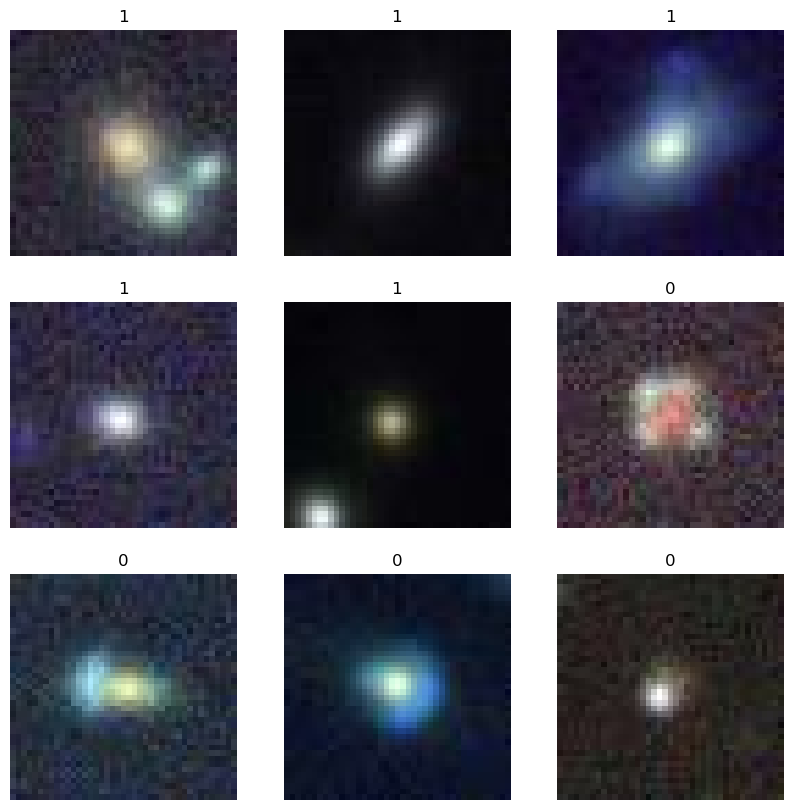

In [31]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [32]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)

In [33]:
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

In [34]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
# keras.utils.plot_model(model, show_shapes=True)

In [35]:
epochs = 25

callbacks = [
    # keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.6861 - loss: 0.5451

2025-08-08 13:07:34.625672: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-08 13:07:34.701950: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-08 13:07:34.816667: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-08 13:07:34.892786: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - acc: 0.6990 - loss: 0.5295

2025-08-08 13:07:39.402173: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-08 13:07:39.478744: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-08 13:07:39.587425: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-08 13:07:39.663854: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - acc: 0.7003 - loss: 0.5278 - val_acc: 0.4520 - val_loss: 0.6888
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.8656 - loss: 0.2951 - val_acc: 0.4520 - val_loss: 0.6888
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.8892 - loss: 0.2645 - val_acc: 0.4520 - val_loss: 0.6911
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9028 - loss: 0.2274 - val_acc: 0.4520 - val_loss: 0.6970
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9162 - loss: 0.2007 - val_acc: 0.5480 - val_loss: 0.7184
Epoch 6/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9239 - loss: 0.1959 - val_acc: 0.5480 - val_loss: 0.7471
Epoch 7/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9338 - loss: 0.1630 - val_acc: 0.5480 - val_loss: 0.8212
Epoch 8/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9265 - loss: 0.1887 - val_acc: 0.5480 - val_loss: 0.9355
Epoch 9/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9372 - loss: 0.1608 -

In [37]:
test_ds = image_dataset_from_directory(
    directory=os.path.join(config['data_dir'], 'test'),
    labels='inferred',
    label_mode='binary',
    color_mode='rgb',
    batch_size=32,
    image_size=image_size,
    shuffle=False,
    interpolation='bilinear',
    verbose=True
)

Found 16 files belonging to 2 classes.


2025-08-08 13:08:43.829603: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-08 13:08:43.906270: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-08 13:08:44.020574: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-08 13:08:44.097053: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


2025-08-08 13:08:44.618456: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


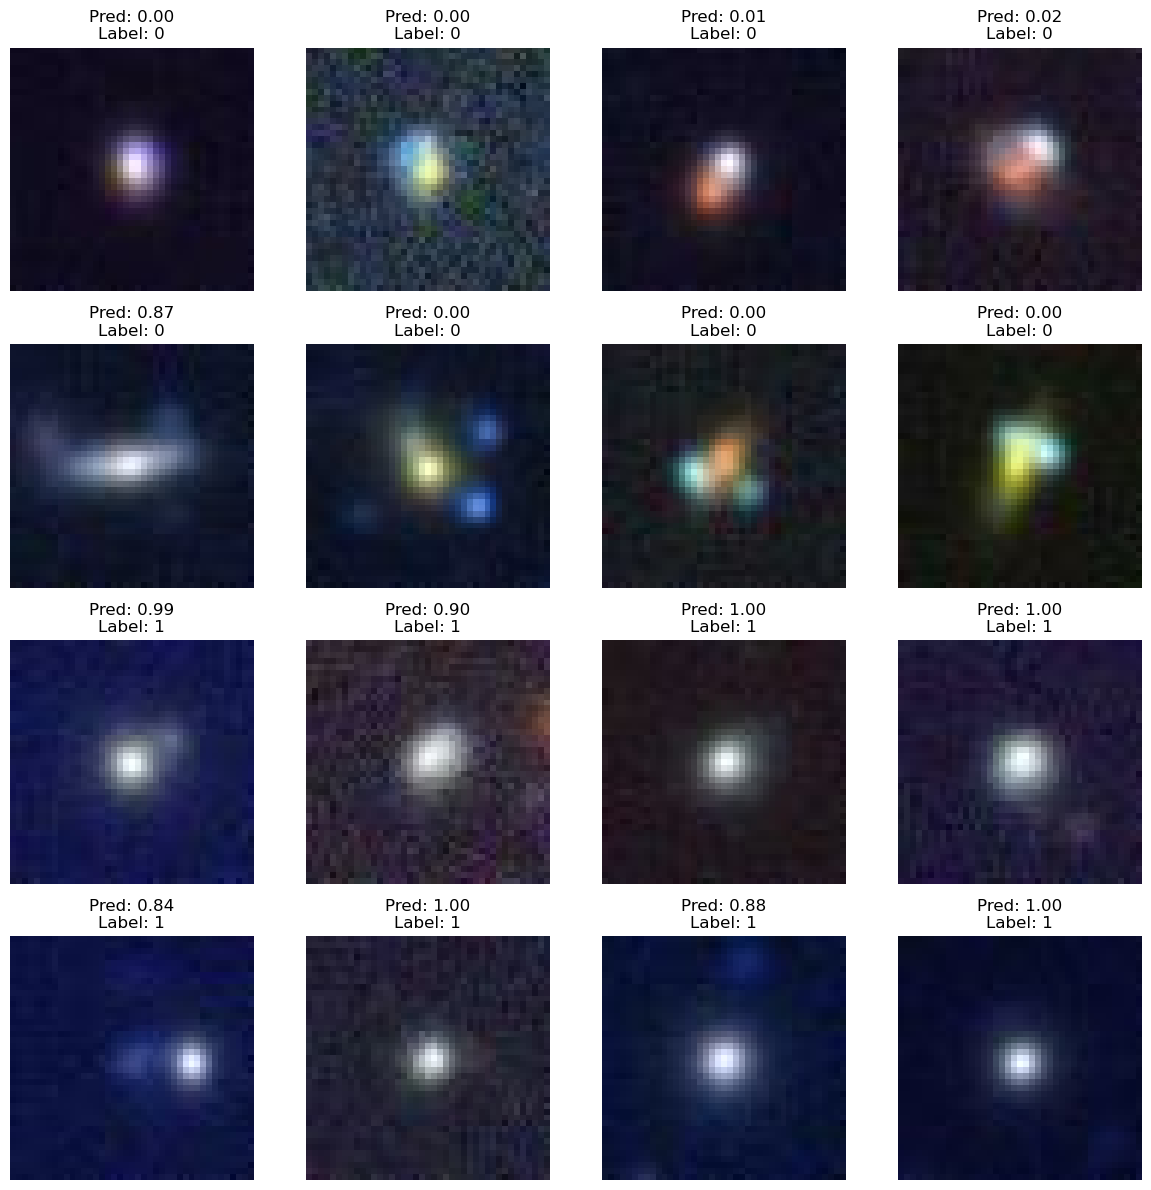

In [38]:
plt.figure(figsize=(12, 12))
for idx, (images_batch, labels_batch) in enumerate(test_ds.take(1)):
    preds = model.predict(images_batch)
    probs = keras.ops.sigmoid(preds).numpy().flatten()
    for i in range(min(16, images_batch.shape[0])):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images_batch[i].numpy().astype("uint8"))
        plt.title(f"Pred: {probs[i]:.2f}\nLabel: {int(labels_batch[i].numpy()[0])}")
        plt.axis("off")
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


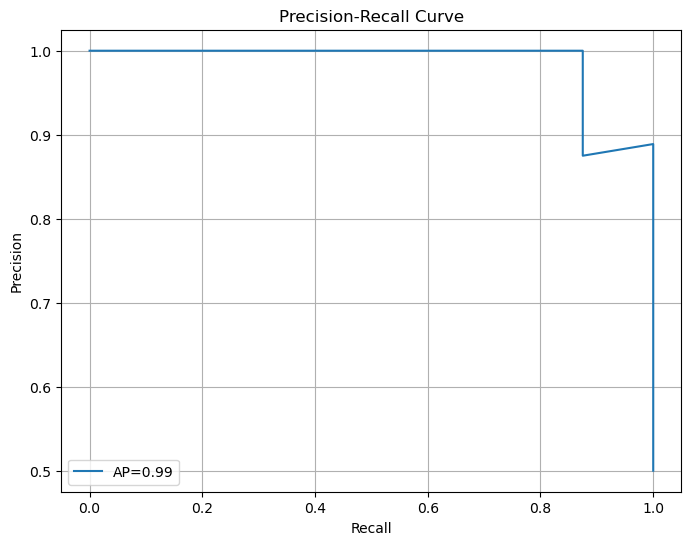

In [39]:
from sklearn.metrics import precision_recall_curve, average_precision_score

import matplotlib.pyplot as plt

# Collect predictions and true labels from test_ds
y_true = []
y_scores = []

for images_batch, labels_batch in test_ds:
    preds = model.predict(images_batch)
    # Use sigmoid to get probabilities
    probs = keras.ops.sigmoid(preds).numpy().flatten()
    y_scores.extend(probs)
    y_true.extend(labels_batch.numpy().flatten())

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
ap_score = average_precision_score(y_true, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AP={ap_score:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()